# ML 3-class Classification  (DR4)

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f3adba64760>

MLfit applied to 4FGL-DR4 

SKlearn specifications: 
* features: log_var, log_fpeak, log_epeak, d
* classes: pulsar, bll, fsrq
* model: SVC(C=1, gamma=2)
        

## Feature distributions 

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f3adb1ebd00>
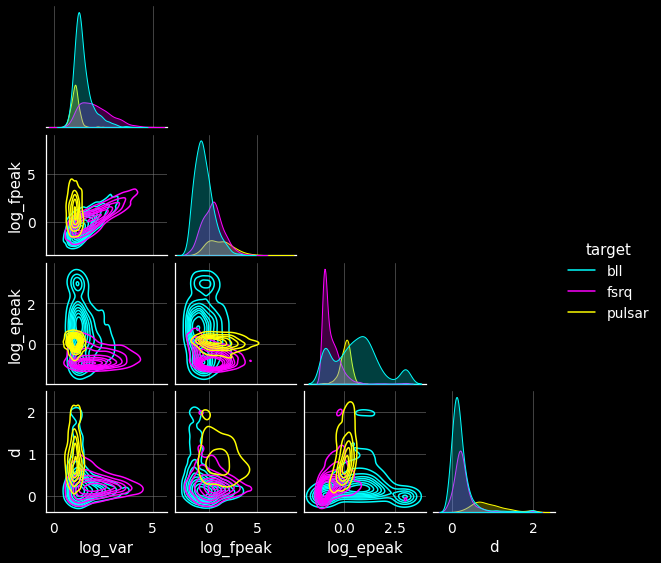

## Train then apply prediction 

### The confusion matrix

prediction,bll,fsrq,pulsar
associations,,,
bll,1364,106,5
fsrq,152,651,5
pulsar,8,7,301


purity=0.97, efficiency=0.95

### All predictions

prediction,bll,fsrq,pulsar
association,,,
bll,1364,106,5
fsrq,152,651,5
psr,3,2,135
msp,5,5,166
glc,7,4,23
bcu,1030,424,100
spp,23,13,69
snr,16,1,24
other,64,42,25


<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f3ad3747400>
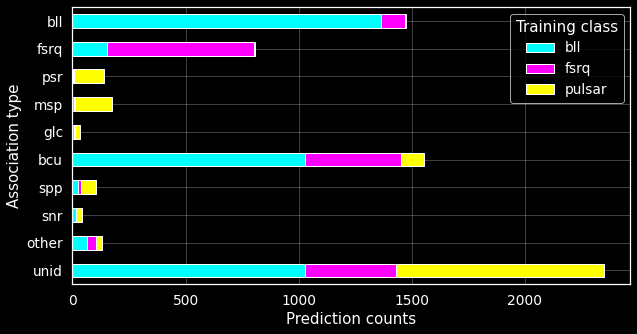

#### Write summary file, adding diffuse correlation

* Load diffuse file,  `/mnt/c/users/thbur/OneDrive/fermi/diffuse/gll_iem_v07_hpx.fits`
  unit=$\rm{eV\ cm^{-2}\ s^{-1}\ deg^{-2}}$
 select energy= 1000 MeV
Wrote 6813-record summary, using model SVC(C=1, gamma=2, probability=True), to `files/dr4_3_class_classification.csv` 
  columns: ['source_type', 'glat', 'glon', 'significance', 'r95', 'Ep', 'Fp', 'd', 'diffuse', 'p_pulsar']


In [1]:
%run pylib/ml_fit show dark
self=doc(3)

In [2]:
    def prediction_association_table(self, df=None):
        """The number of sources classified as each of the  targets, according to the 
        association type.
        """
        if df is None: df = self.df.copy()
        
        # combine a bunch of the class1 guys into "other"
        def make_other(s):
            if s in 'bll fsrq psr msp bcu spp snr glc unid'.split():
                return s
            return 'other'
            
        df.loc[:,'association'] = df.association.apply(make_other).values
        def simple_pivot(df, x='prediction', y= 'association'):        
            ret =df.groupby([x,y]).size().reset_index().pivot(
                columns=x, index=y, values=0)
            return ret.reindex(index='bll fsrq psr msp glc bcu spp snr other unid'.split())
            
        t=simple_pivot(df)
        t[np.isnan(t)]=0
        return t.astype(int)

In [3]:
from pylib.catalogs import Fermi4FGL
self.load_data(fgl)


NameError: name 'fgl' is not defined

In [ ]:
self.df.groupby('association').size()
prediction_association_table(self)

In [ ]:
fgl = Fermi4FGL()

In [ ]:
fgl.groupby('class1').size()
sum( (fgl.r95>0) 
  | (fgl.class1=='SNR')
   ) 

In [ ]:
show(f"""---
# Addendum
Select unid subset with R95<8 arcsec""")

In [ ]:
unid = self.df.query('association=="unid"')
ax = sns.histplot( x=(unid.r95*60).clip(0,30), element='step', label='all unid', bins=np.arange(0,30,0.5))
ax.set(xlabel='R95 (arcmin)')
ax.axvline(8, ls='--', color='w')
ax.legend()
keep = unid[unid.r95<8/60]
show(f"""## R95 distribution for unids
""")
show(ax.figure)

all = pd.Series(unid.groupby('prediction').size(), name='all')
kept =pd.Series(keep.groupby('prediction').size(), name='R95<8 arcmin')
lowerlat =pd.Series(keep.query('-30<glat<30').groupby('prediction').size(), name='also |b|<30')  
plane =pd.Series(keep.query('-3<glat<3').groupby('prediction').size(), name='or |b|<3')  

t =pd.DataFrame([all, kept, lowerlat, plane]); t.index.name='Counts'
show(t)

In [ ]:
z = np.abs(np.sin(np.radians(unid.glat)))
kw = dict(bins=30, #bins=np.logspace(1,3,31,), 
          element='step', log_scale=(True,False))
fig, ax= plt.subplots()
sns.histplot(unid.significance, ax=ax, **kw, label='all');
sns.histplot(keep.significance, ax=ax, **kw, label='R95<8', edgecolor='k');
ax.set(xticks=[ 10, 100,])
ax.legend()

In [ ]:
dfout = keep['glat glon significance r95 variability Ep Fp d prediction'.split()]
dfout.to_csv('files/4FGL_DR4_unid_8arcmin.csv', float_format='%.3f')

In [ ]:
df=self.df; 
fig, ax= plt.subplots(figsize=(6,3))
kw = dict(ax=ax, x='variability', element='step', log_scale=(True, False), )
sns.histplot(df, **kw,label='all' )
ax=sns.histplot(df.query('association=="unid"'), **kw , edgecolor='k', label='unid')
ax.legend();
show(fig)             

In [ ]:
unid = df.query('association=="unid" & variability>25')
unid.sort_values('variability', ascending=False).groupby('prediction').size()

In [ ]:
unid.query('prediction=="bll"& variability>30').sort_values('variability', ascending=False)

In [ ]:

%run pylib/compare_accuracy
names=('Neural Net',"RBF SVM","Random Forest")

classifiers=(MLPClassifier(alpha=1, max_iter=1000),SVC(gamma=2, C=1,probability=True), RandomForestClassifier(n_estimators=100, max_features=2))

test = Compare_Classifiers(fs_data.getXy(specs1), unid.getXy(specs2),'files/test',names=names, classifiers=classifiers)


#Takes a tuple of classifiers and a tuple of their names
def pltAvgPrecRec(classifiers, names, X, y, Axis=None):

    import seaborn as sns
    import sklearn
    from sklearn.metrics import PrecisionRecallDisplay
    import matplotlib.pyplot as plt

    def getPrecRec(theX, they, clf, ax=None):
        X_train, X_test, y_train, y_test = train_test_split(theX, they, test_size=0.333)

        classifier = clf.fit(X_train, y_train)

        #Get precision and recall values
        tem = PrecisionRecallDisplay.from_estimator(
            classifier, X_test, y_test, name=name, ax=ax, plot_chance_level=True
        )
        tem.figure_.clear()

        return tem

    #set up
    thePrec = np.empty(0)
    theRecall = np.empty(0)
    theSet = np.empty(0)
    
    
    #Loop through classifiers
    for name, clf in zip(names, classifiers):
    
        they = (y=='psr')

        pr = getPrecRec(X, they, clf, Axis)

        count = 0
        prec = pr.precision
        recall = pr.recall


        while((count:=count+1) <= 20):

            pr = getPrecRec(X, they, clf, Axis)

            if prec.size < pr.precision.size:
                prec += pr.precision[:prec.size]
                recall += pr.recall[:recall.size]
            else:
                p = np.ones(prec.size)
                r = np.ones(recall.size)

                p = prec/count
                r = recall/count

                p[:pr.precision.size] = pr.precision
                r[:pr.recall.size] = pr.recall
                prec += p
                recall += r



        theSet = np.concatenate((theSet, np.full((prec.size), name)))
        thePrec = np.concatenate((thePrec, prec/count))
        theRecall = np.concatenate((theRecall, recall/count))

    prdf = pd.DataFrame(data={"prec": thePrec, 
                              "recall": theRecall, 
                              "group": theSet})

    plot = sns.lineplot(data=prdf, x="recall", y="prec", hue='group')
    
    return plot
    
a = (SVC(gamma=2, C=1),RandomForestClassifier(n_estimators=100, max_features=2),MLPClassifier(alpha=1, max_iter=1000),)
b = ("svc", "RF", "Neural",)
t = pltAvgPrecRec(a, b, test.X, test.y,)

t.figure

In [ ]:
show("""---
## Test precision/recall""")

In [ ]:
show(f"""### The confusion matrix""")
cmdf = self.confusion_matrix()
show(cmdf)